### 1.1 PCA scores/cNMF weights with EDS element

In [1]:
import pandas as pd
import numpy as np
from orix import io
import kikuchipy as kp
import ast
from data_preprocessing import get_eds_average, preprocess_features, coord_xmap_dict
from contrastivemodel import train_and_evaluate
from visualize_contrastive import visualize_loss_curve, visualize_contrastive_embeddings, visualize_contrastive_embeddings_by_element, visualize_contrastive_embeddings_by_phase

c:\Users\Angelamer\anaconda3\envs\kikuchi_cnmf\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pca_scores= pd.read_csv('../micro_segmentation/pca_scores1.csv',  header=None, skiprows=1)  # shape (961,10)
pca_scores.iloc[:, 0] = pca_scores.iloc[:, 0].apply(
    lambda s: ast.literal_eval(s) if isinstance(s, str) else s
)

cnmf_w    = pd.read_csv('../micro_segmentation/weight1.csv', header=None, skiprows=1) # shape (961,2)
loc =pca_scores.iloc[:,0]

pca_scores = pca_scores.iloc[:,1:]
cnmf_w = cnmf_w.iloc[:,1:]
pca_scores.columns= [f'PC_{i+1}'   for i in pca_scores.columns]
cnmf_w.columns    = ['cNMF_1', 'cNMF_2']
roi_xrange=(20, 51)
roi_yrange=(5, 36)
edax_binary_path = "../EBSD_scan/Scan3_cropped.up1"
fname_ang = "../EBSD_scan/Scan3_cropped.ang"
xmap = io.load(fname_ang)

xmap.prop["iq"] = xmap.prop.pop("unknown1")
xmap.prop["ci"] = xmap.prop.pop("unknown2")
xmap.prop["sem"] = xmap.prop.pop("unknown3")
xmap.prop["fit"] = xmap.prop.pop("unknown4")
xmap.prop["bs"] = xmap.prop.pop("unknown5")
xmap.prop["cs"] = xmap.prop.pop("unknown6")
xmap.prop["ts"] = xmap.prop.pop("unknown7")
xmap.prop["oxygen"] = xmap.prop.pop("unknown8")
xmap.prop["Mg"] = xmap.prop.pop("unknown9")
xmap.prop["Al"] = xmap.prop.pop("unknown10")
xmap.prop["Si"] = xmap.prop.pop("unknown11")
xmap.prop["Ti"] = xmap.prop.pop("unknown12")
xmap.prop["Mn"] = xmap.prop.pop("unknown13")
xmap.prop["Fe"] = xmap.prop.pop("unknown14")
s_edax = kp.load(edax_binary_path)
s_edax.xmap = xmap
coor_dict = coord_xmap_dict(s_edax.inav[20:51,5:36].xmap,0.05)
roi_eds = get_eds_average(roi_xrange, roi_yrange, s_edax, 'roi')
def normalize_roi_data_vectorized(roi_data):
    row_sums = np.nansum(roi_data, axis=1)

    row_sums[row_sums == 0] = 1
    
    normalized_data = roi_data / row_sums[:, np.newaxis]
    
    all_nan_rows = np.all(np.isnan(roi_data), axis=1)
    normalized_data[all_nan_rows] = 0
    
    return normalized_data
roi_eds = normalize_roi_data_vectorized(roi_eds)
roi_eds = pd.DataFrame(roi_eds, columns=['O', 'Mg', 'Al', 'Si', 'Ti', 'Mn', 'Fe'])
all_data = pd.concat([pca_scores, cnmf_w, roi_eds], axis=1)


c:\Users\Angelamer\anaconda3\envs\kikuchi_cnmf\Lib\site-packages\orix\io\plugins\ang.py:285: UserWarning: Number of columns, 20, in the file is not equal to the expected number of columns, [14, 10], for the 
assumed vendor 'tsl'. Will therefore assume the following columns: euler1, euler2, euler3, x, y, unknown1, unknown2, phase_id, unknown3, unknown4, etc.
  warnings.warn(


In [3]:
all_data = preprocess_features(all_data)

In [4]:
train_idx = np.random.choice(len(all_data), int(0.8*len(all_data)), replace=False)
test_idx = np.array(list(set(range(len(all_data))) - set(train_idx)))
train_data = all_data.iloc[train_idx]
test_data = all_data.iloc[test_idx]

loc_testdata = loc.iloc[test_idx]

In [5]:
# Train the model
print("Training PCA Model...")
pca_model, pca_train_losses, pca_test_losses = train_and_evaluate(
    'pca', train_data, test_data, output_dim=3, num_epochs=40, batch_size=31, lr=1e-3
)

print("\nTraining cNMF Model...")
cnmf_model, cnmf_train_losses, cnmf_test_losses = train_and_evaluate(
    'cnmf', train_data, test_data, output_dim=3, num_epochs=40, batch_size=31, lr=1e-3
)

Training PCA Model...
Epoch [1/40], PCA Model - Train Loss: 4.2266, Test Loss: 3.8920
Epoch [2/40], PCA Model - Train Loss: 4.1000, Test Loss: 3.8929
Epoch [3/40], PCA Model - Train Loss: 4.0903, Test Loss: 3.8754
Epoch [4/40], PCA Model - Train Loss: 4.0758, Test Loss: 3.8441
Epoch [5/40], PCA Model - Train Loss: 4.0552, Test Loss: 3.8304
Epoch [6/40], PCA Model - Train Loss: 4.0286, Test Loss: 3.8974
Epoch [7/40], PCA Model - Train Loss: 4.0119, Test Loss: 3.8223
Epoch [8/40], PCA Model - Train Loss: 3.9946, Test Loss: 3.7818
Epoch [9/40], PCA Model - Train Loss: 3.9854, Test Loss: 3.8072
Epoch [10/40], PCA Model - Train Loss: 3.9707, Test Loss: 3.7733
Epoch [11/40], PCA Model - Train Loss: 3.9574, Test Loss: 3.8091
Epoch [12/40], PCA Model - Train Loss: 3.9497, Test Loss: 3.7474
Epoch [13/40], PCA Model - Train Loss: 3.9329, Test Loss: 3.7587
Epoch [14/40], PCA Model - Train Loss: 3.9262, Test Loss: 3.9254
Epoch [15/40], PCA Model - Train Loss: 3.9255, Test Loss: 3.9253
Epoch [16/40

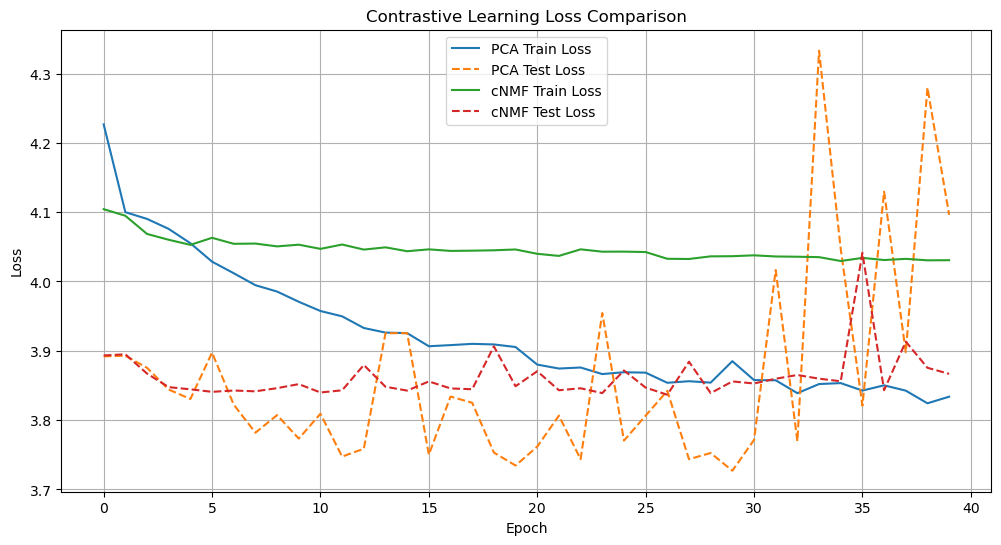

In [6]:
visualize_loss_curve(pca_model, cnmf_model, test_data, pca_train_losses, pca_test_losses, cnmf_train_losses, cnmf_test_losses)

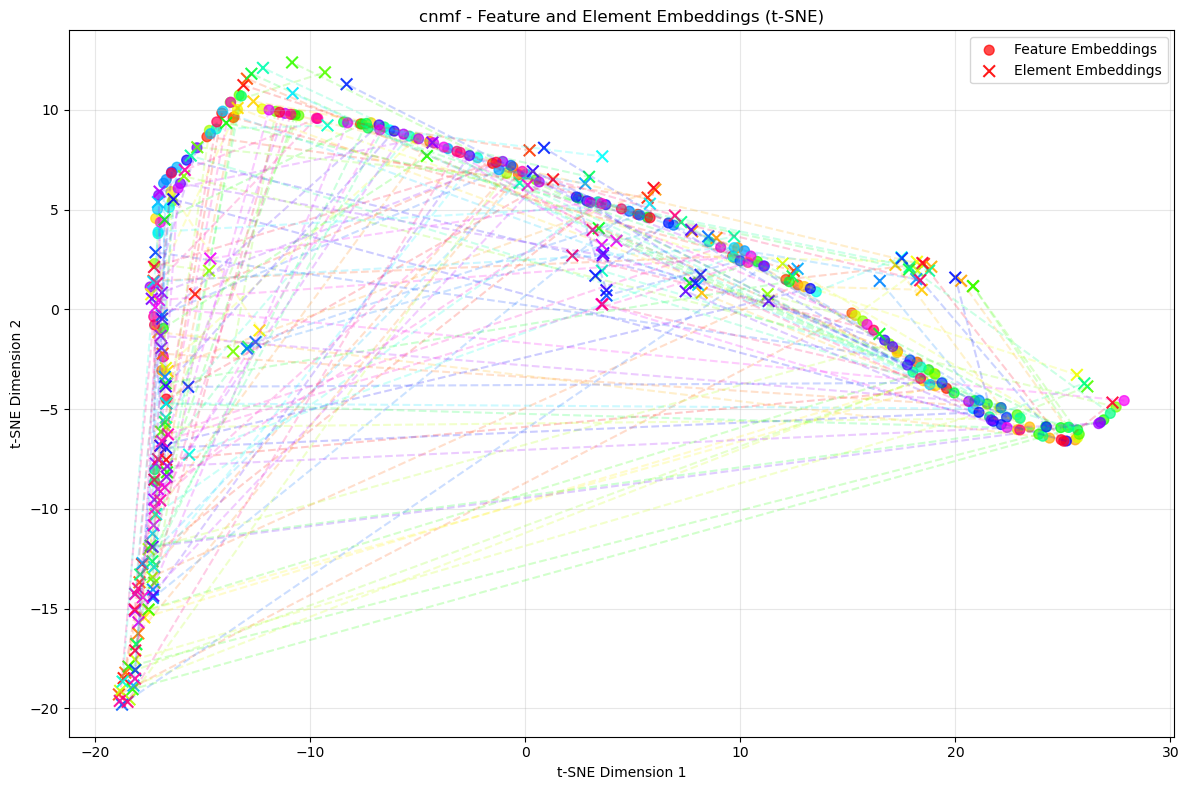

Average distance between feature and element embeddings: 20.7073


In [7]:
feature_tsne, element_tsne, distances = visualize_contrastive_embeddings(cnmf_model, test_data, 'cnmf')


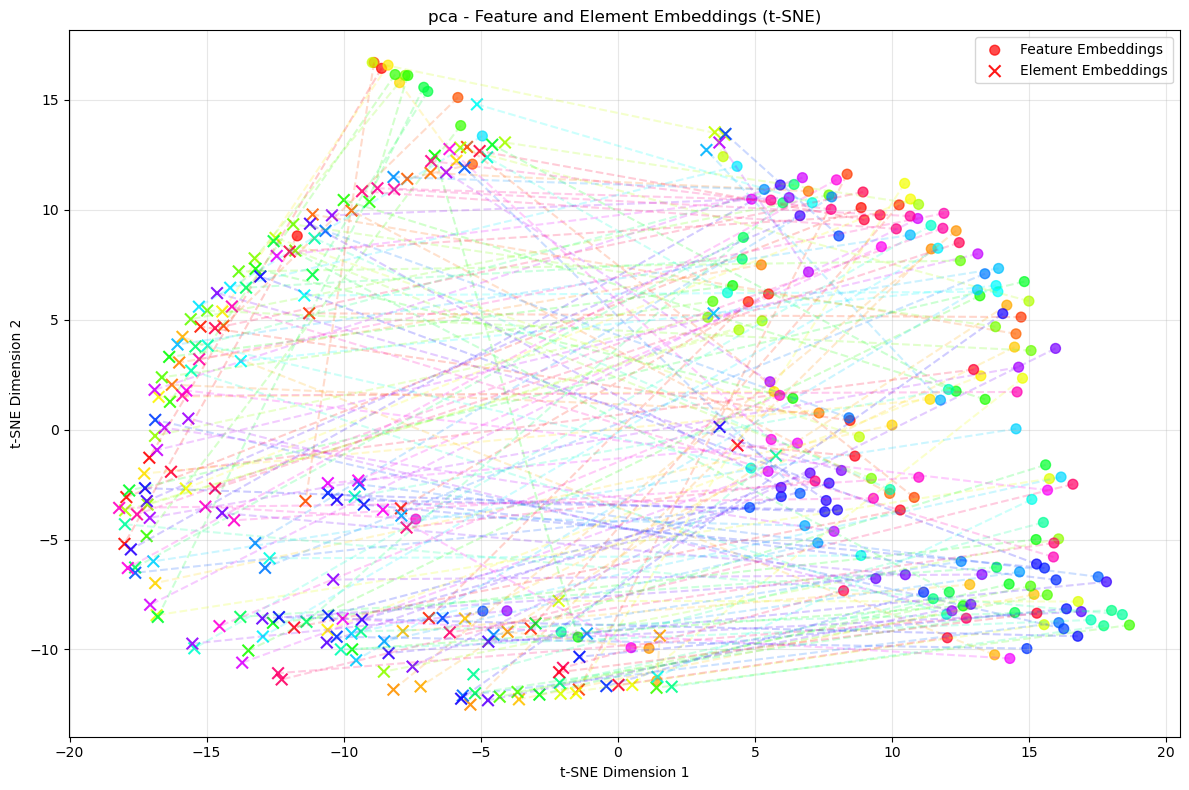

Average distance between feature and element embeddings: 21.4849


In [8]:
feature_tsne, element_tsne, distances = visualize_contrastive_embeddings(pca_model, test_data, 'pca')

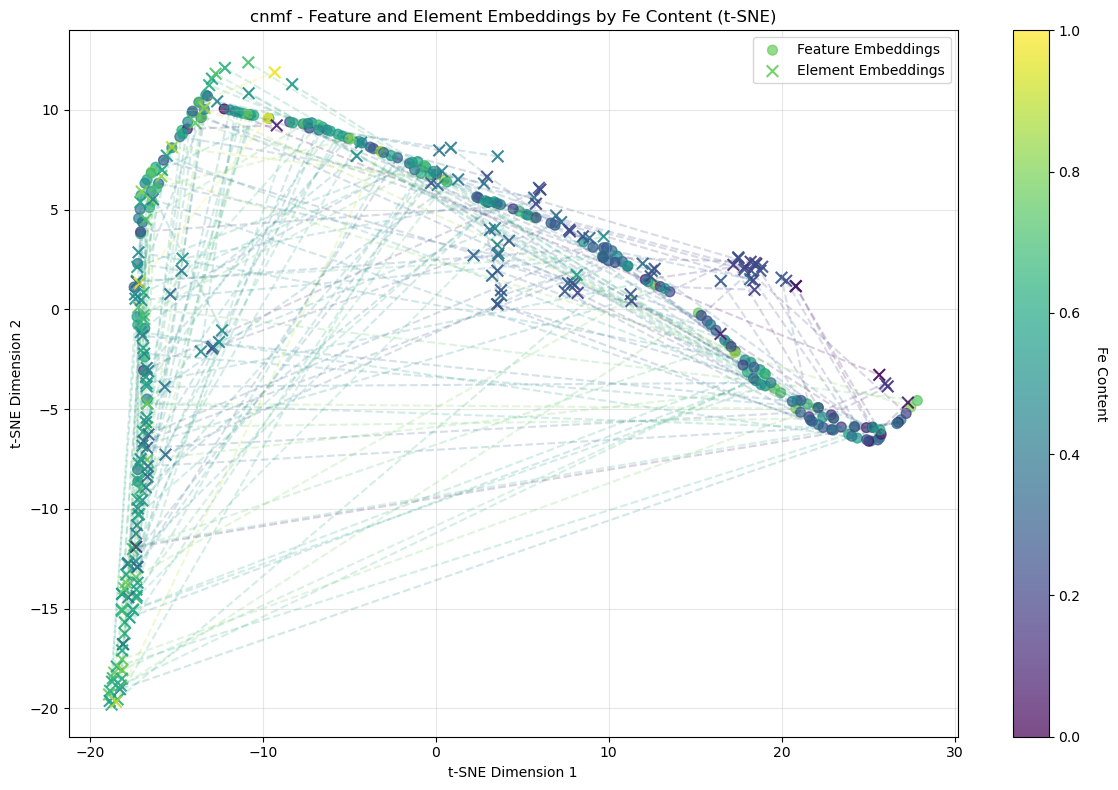

Average distance between feature and element embeddings: 20.7073
Correlation between distance and Fe content: 0.3947


In [9]:
feature_tsne, element_tsne, distances = visualize_contrastive_embeddings_by_element(cnmf_model, test_data, 'cnmf', 'Fe')

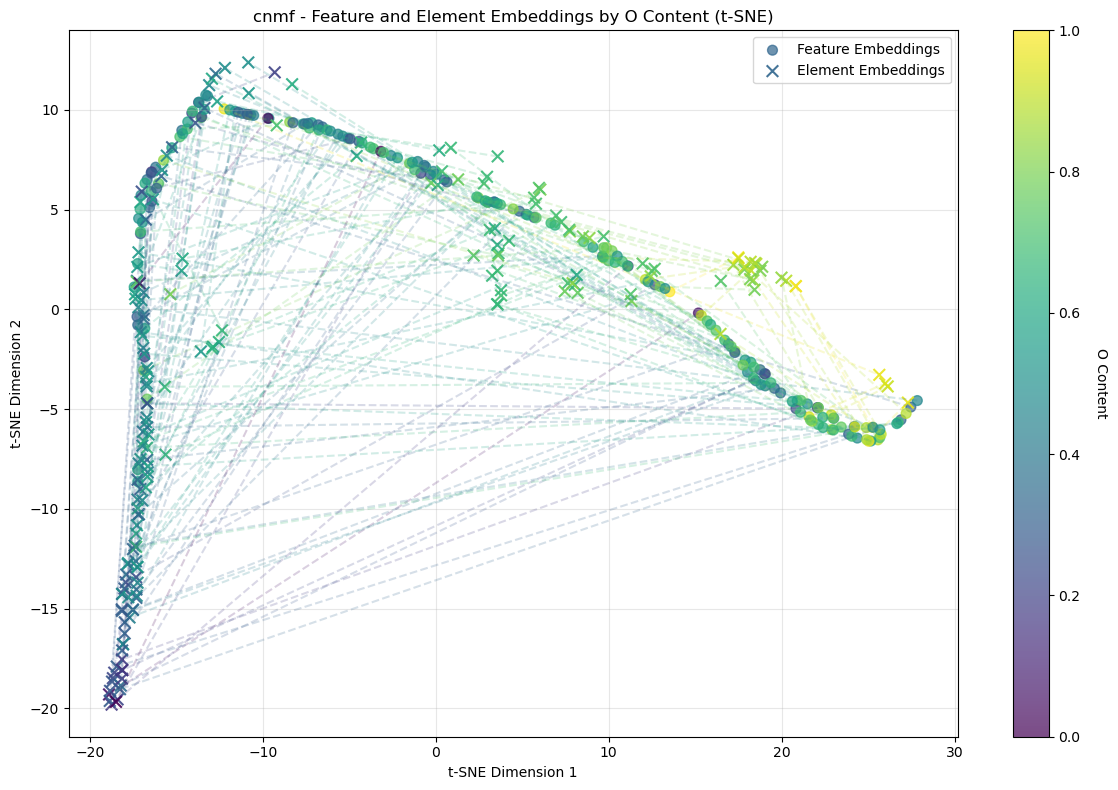

Average distance between feature and element embeddings: 20.7073
Correlation between distance and O content: -0.4728


In [11]:
feature_tsne, element_tsne, distances = visualize_contrastive_embeddings_by_element(cnmf_model, test_data, 'cnmf', 'O')

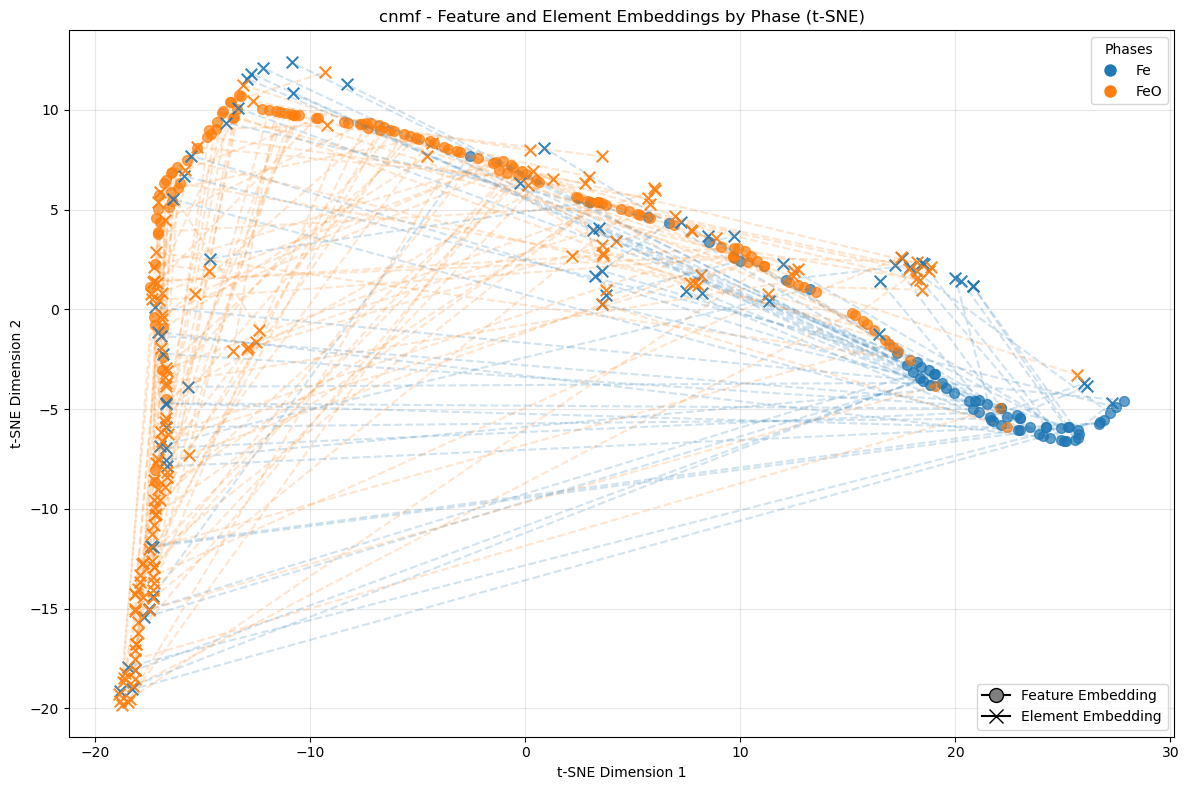

Average distance between feature and element embeddings: 20.7073

Distance by phase:
Fe: 25.5046
FeO: 18.4368


In [10]:
phase_map = {2: 'FeO', 3: 'Fe'}
feature_tsne, element_tsne, distances = visualize_contrastive_embeddings_by_phase(cnmf_model, test_data, loc_testdata, coor_dict, phase_map, 'cnmf')

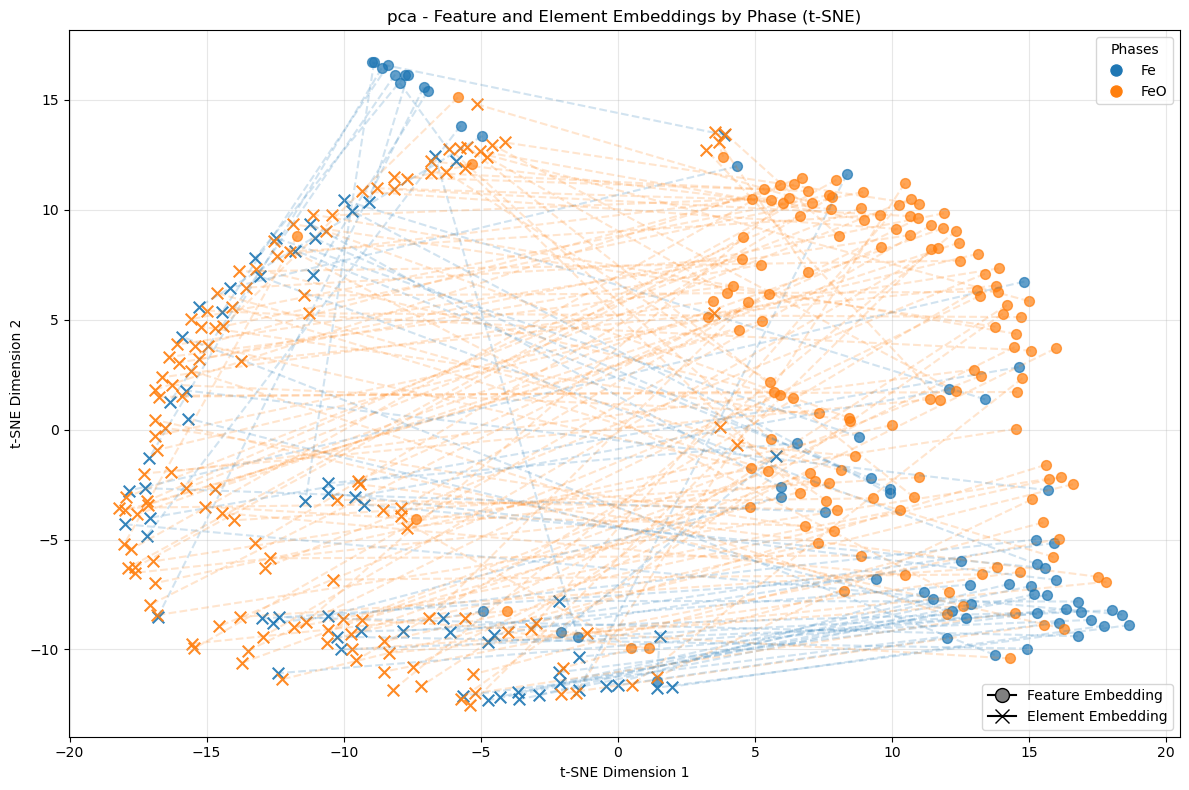

Average distance between feature and element embeddings: 21.4849

Distance by phase:
Fe: 20.4418
FeO: 21.9786


In [12]:
feature_tsne, element_tsne, distances = visualize_contrastive_embeddings_by_phase(pca_model, test_data, loc_testdata, coor_dict, phase_map, 'pca')

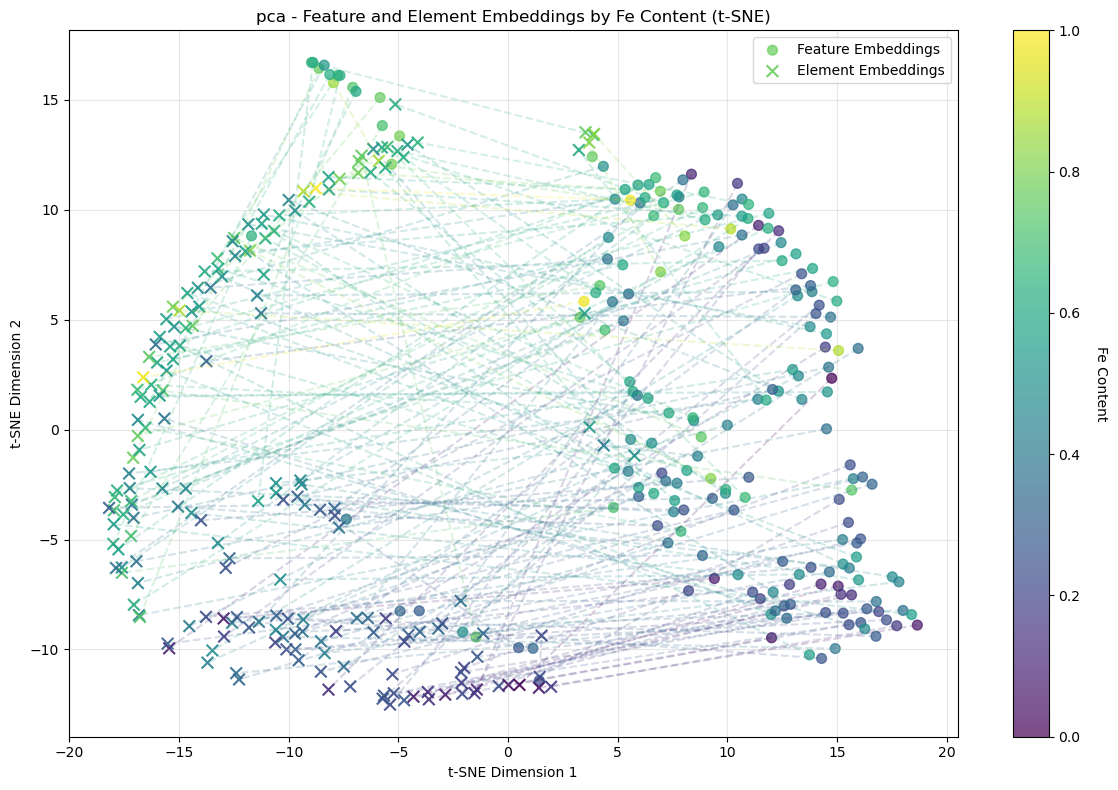

Average distance between feature and element embeddings: 21.4849
Correlation between distance and Fe content: -0.1069


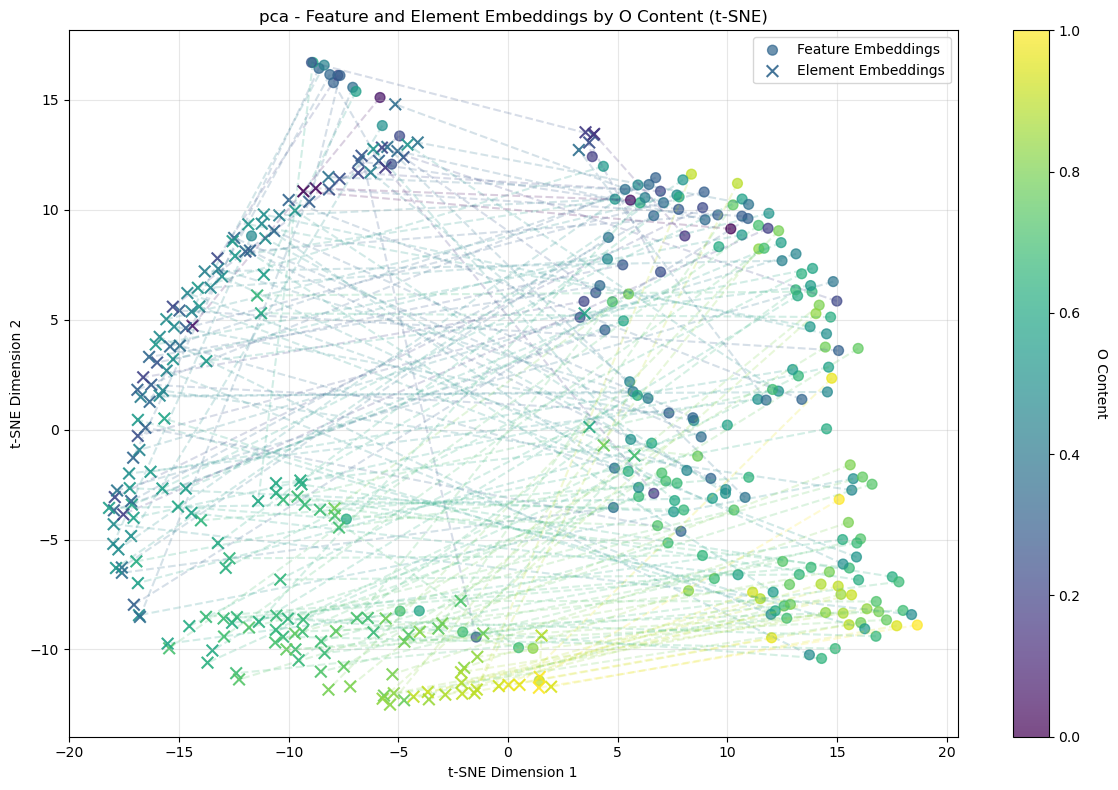

Average distance between feature and element embeddings: 21.4849
Correlation between distance and O content: 0.0334


In [13]:
feature_tsne, element_tsne, distances = visualize_contrastive_embeddings_by_element(pca_model, test_data, 'pca', 'Fe')
feature_tsne, element_tsne, distances = visualize_contrastive_embeddings_by_element(pca_model, test_data, 'pca', 'O')